In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
data = pd.read_excel(r"20210922Renter.xlsx")

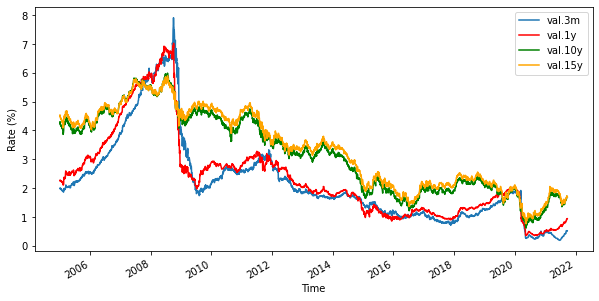

In [3]:
plt.figure(figsize=(10,5))
ax = plt.gca()
data.plot(kind='line',x='date.3m', y='val.3m', ax=ax)
data.plot(kind='line',x='date.1y', y='val.1y', color='red', ax=ax)
data.plot(kind='line',x='date.10y', y='val.10y', color='green', ax=ax)
data.plot(kind='line',x='date.15y', y='val.15y', color='orange', ax=ax)
plt.ylabel("Rate (%)")
plt.xlabel("Time")
plt.show()

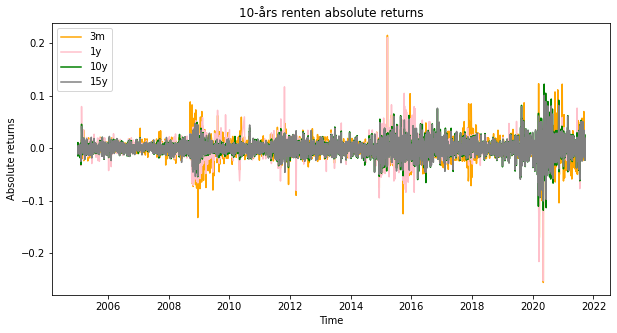

In [4]:

#absolute returns (easier to see daily change)
data_3m_returns = data['val.3m'].pct_change()
data_1y_returns = data['val.1y'].pct_change()
data_10y_returns = data['val.10y'].pct_change()
data_15y_returns = data['val.15y'].pct_change()

#plot absolute returns
plt.figure(figsize=(10,5))
plt.plot(data['date.3m'],data_3m_returns, color='orange', label="3m")
plt.plot(data['date.1y'],data_1y_returns, color='pink', label="1y")
plt.plot(data['date.10y'],data_10y_returns, color='green', label="10y")
plt.plot(data['date.15y'],data_15y_returns, color='grey', label="15y")
plt.title('10-års renten absolute returns')
plt.ylabel("Absolute returns")
plt.xlabel("Time")
plt.legend()
plt.show()



## En-faktor model: Vasicek


$$dr= \kappa (\theta - r) dt + \sigma dW$$

hvor $W$ er tilfeldig markedsrisiko, $\kappa$ er farten på reversjonen mot forventningsverdien, $\theta$ er long-term level av forventningsverdien, og $\sigma$ er volatiliteten.

Leddet $\kappa (\theta - r)$ kalles drift factor og representerer forventet instant forandring i renten for tiden t.


Løsning:

$$ 
r_ti = r_t(i-1) exp(-\kappa(T_i-t_{i-1})) + \theta (1- exp(-k\kappa(t_i - t_{i-1}))) + Z\sqrt{\frac{\sigma^2(1-exp(-2\kappa(t_i-t_{i-1}))}{2\kappa}} 
$$

der $Z\sim N(0,1)$



In [5]:
def VasicekNextRate(r, kappa, theta, sigma, dt=1/252):
  # Implements above closed form solution
  val1 = np.exp(-1*kappa*dt)
  val2 = (sigma**2)*(1-val1**2) / (2*kappa)
  out = r*val1 + theta*(1-val1) + (np.sqrt(val2))*np.random.normal()
  return out

# Vasicek simulation short rate
def VasicekSim(N, r0, kappa, theta, sigma, dt = 1/252):
  short_r = [0]*N # Create array to store rates
  short_r[0] = r0 # Initialize rates at $r_0$
  for i in range(1,N):
    short_r[i]=VasicekNextRate(short_r[i-1],kappa, theta, sigma, dt)
  return short_r

# Vasicek multi-simulation
def VasicekMultiSim(M, N, r0, kappa, theta, sigma, dt = 1/252):
  sim_arr = np.ndarray((N, M))
  for i in range(0,M):
    sim_arr[:, i] = VasicekSim(N, r0, kappa, theta, sigma, dt)
  return sim_arr

# Maximum Likelihood Estimation to calibrate parameters
def VasicekCalibration(rates, dt=1/252):
  n = len(rates)
  Ax = sum(rates[0:(n-1)])
  Ay = sum(rates[1:n])
  Axx = np.dot(rates[0:(n-1)], rates[0:(n-1)])
  Axy = np.dot(rates[0:(n-1)], rates[1:n])
  Ayy = np.dot(rates[1:n], rates[1:n])
  theta = (Ay * Axx - Ax * Axy) / (n * (Axx - Axy) - (Ax**2 - Ax*Ay))
  kappa = -np.log((Axy - theta * Ax - theta * Ay + n * theta**2) / (Axx - 2*theta*Ax + n*theta**2)) / dt
  a = np.exp(-kappa * dt)
  sigmah2 = (Ayy - 2*a*Axy + a**2 * Axx - 2*theta*(1-a)*(Ay - a*Ax) + n*theta**2 * (1-a)**2) / n
  sigma = np.sqrt(sigmah2*2*kappa / (1-a**2))
  r0 = rates[n-1]
  return [kappa, theta, sigma, r0]


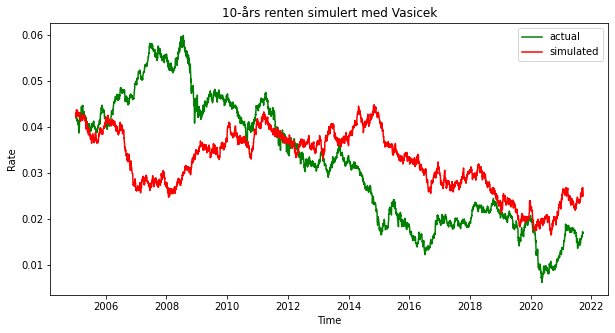

In [6]:
#10års renten

#hent ut parametere
params=VasicekCalibration(data['val.10y'].dropna()/100)
kappa = params[0]
theta = params[1]
sigma = params[2]
r0 = data['val.10y'][0]/100

#hent ut x- og y-verdier
days = len(data['date.10y'])
t = data['date.10y']
test_sim = VasicekSim(days, r0, kappa, theta, sigma, 1/252)

#plot av simulert vs. faktisk 10-års rente
plt.figure(figsize=(10,5))
plt.plot(t,data['val.10y']/100, color='green', label='actual')
plt.plot(t,test_sim, color='red', label='simulated')
plt.title('10-års renten simulert med Vasicek')
plt.ylabel("Rate")
plt.xlabel("Time")
plt.legend()
plt.show()

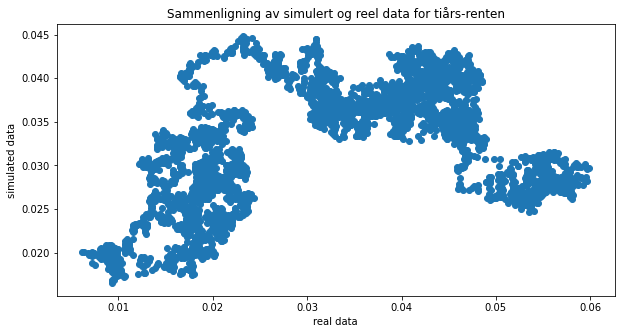

In [7]:
#scatter plot of simulated and real line 
plt.figure(figsize=(10,5))
plt.scatter(x =data['val.10y']/100 , y=test_sim)
plt.title('Sammenligning av simulert og reel data for tiårs-renten')
plt.ylabel("simulated data")
plt.xlabel("real data")
plt.show()



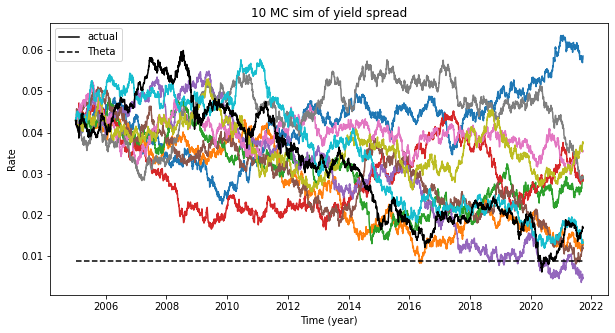

In [8]:
#monte carlo 

M = 10
rates_arr = VasicekMultiSim(M, days, r0, kappa, theta, sigma)

plt.figure(figsize=(10,5))
plt.plot(t,rates_arr)
plt.hlines(y=theta, xmin = t[0], xmax=t[len(t)-1], zorder=10, linestyles = 'dashed', label='Theta', color="black")
plt.plot(t,data['val.10y']/100, color='black', label='actual')
plt.ylabel("Rate")
plt.xlabel("Time (year)")
plt.title('10 MC sim of yield spread')
plt.legend()
plt.show()

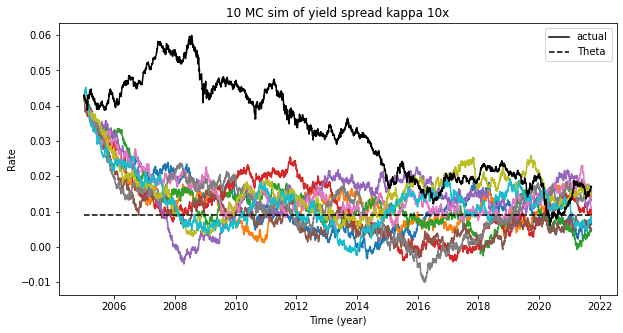

In [9]:
#nå: leke med parametere, feks theta:

rates_10kappa = VasicekMultiSim(10, days, r0, kappa*10, theta, sigma)


plt.figure(figsize=(10,5))
plt.plot(t,rates_10kappa)
plt.hlines(y=theta, xmin = t[0], xmax=t[len(t)-1], zorder=10, linestyles = 'dashed', label='Theta', color="black")
plt.plot(t,data['val.10y']/100, color='black', label='actual')
plt.ylabel("Rate")
plt.xlabel("Time (year)")
plt.title('10 MC sim of yield spread kappa 10x')
plt.legend()
plt.show()


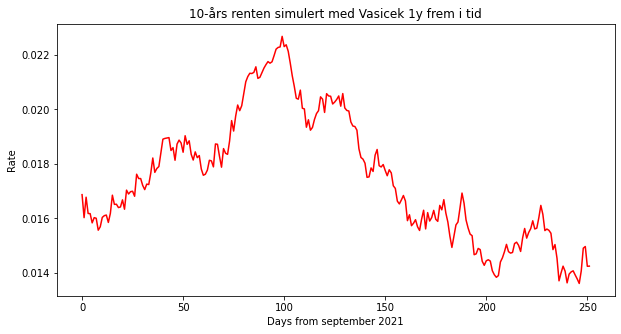

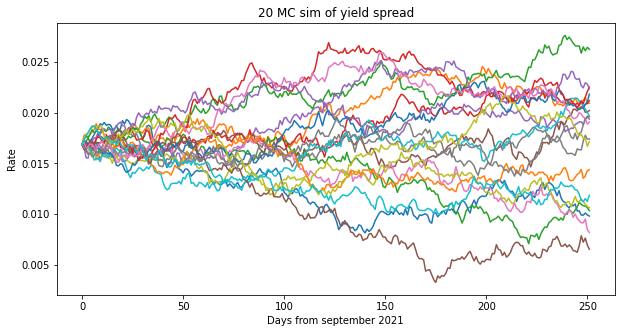

In [10]:
#10års frem i tid
days = len(data['date.10y'])
rend = data['val.10y'][days-1]/100

N = 252*1 #1y fram i tid
t = np.arange(0,N)
test_sim_future = VasicekSim(N, rend, kappa, theta, sigma, 1/252)

#plot av simulert vs. faktisk 10-års rente
plt.figure(figsize=(10,5))
plt.plot(t,test_sim_future, color='red')
plt.title('10-års renten simulert med Vasicek 1y frem i tid')
plt.ylabel("Rate")
plt.xlabel("Days from september 2021")
plt.show()

rates_future = VasicekMultiSim(500, N, rend, kappa, theta, sigma)

plt.figure(figsize=(10,5))
plt.plot(t,rates_future[:,0:20])
# plt.hlines(y=theta, xmin = t[0], xmax=t[len(t)-1], zorder=10, linestyles = 'dashed', label='Theta', color="black")
plt.ylabel("Rate")
plt.xlabel("Days from september 2021")
plt.title('20 MC sim of yield spread')
plt.show()


Text(0.5, 1.0, 'Fordelingen av simuleringer for rentedata 1 år frem i tid, p(r(t1)|r(t0);H)')

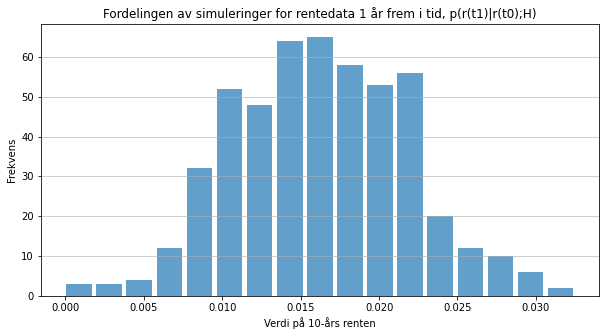

In [11]:
# velg siste dag (altså dag nr. 251)
# bruker parametere basert på historisk data fra 10-årsrenten funnet ved MLE
t1 = rates_future[-1,:]
plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(x=t1, bins='auto',
                            alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Verdi på 10-års renten')
plt.ylabel('Frekvens')
plt.title('Fordelingen av simuleringer for rentedata 1 år frem i tid, p(r(t1)|r(t0);H)')



Dette samstemmer med approksiamsjoner i modellen om normalfordelte variabler.
Forteller oss hvordan renten er fordelt over et intervall med forventnignsverdi og kvantiler om et år. Mye brukt hvis man skal sette fremtidig verdi med usikkerhet. 

In [ ]:
# må fikse slik at Nan verdier fjernes 

# 3månders renten
# data['val.3m'] = data['val.3m'].dropna()
# data['date.3m'] = data['date.3m'].dropna()
# print(data['val.3m'])

# params=VasicekCalibration(data['val.3m']/100)
# kappa = params[0]
# theta = params[1]
# sigma = params[2]
# r0 = data['val.3m'][0]/100
# print(r0)

# #1 år frem i tid
# days = len(data['date.3m'])
# print(data['val.3m'][days-2])
# rend = data['val.3m'][days-1]/100

# test_sim = VasicekSim(days, r0, kappa, theta, sigma, 1/252)

# N = 252*1 #1y fram i tid
# t = np.arange(0,N)
# future_3m_rates = VasicekSim(N, rend, kappa, theta, sigma, 1/252)

# #plot av simulert vs. faktisk 10-års rente
# plt.figure(figsize=(10,5))
# plt.plot(t,future_3m_rates, color='red')
# plt.title('3-mnds renten simulert med Vasicek 1y frem i tid')
# plt.ylabel("Rate")
# plt.xlabel("Days from september 2021")
# plt.show()

# rates_future = VasicekMultiSim(500, N, rend, kappa, theta, sigma)

# plt.figure(figsize=(10,5))
# plt.plot(t,rates_future[:,0:20])
# # plt.hlines(y=theta, xmin = t[0], xmax=t[len(t)-1], zorder=10, linestyles = 'dashed', label='Theta', color="black")
# plt.ylabel("Rate")
# plt.xlabel("Days from september 2021")
# plt.title('20 MC sim of yield spread')
# plt.show()

# velg siste dag (altså dag nr. 251)
# bruker parametere basert på historisk data fra 10-årsrenten funnet ved MLE
# t1 = rates_future[-1,:]
# plt.figure(figsize=(10,5))
# n, bins, patches = plt.hist(x=t1, bins='auto',
#                             alpha=0.7, rwidth=0.85)

# plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Verdi på 3mnd-renten')
# plt.ylabel('Frekvens')
# plt.title('Fordelingen av simuleringer for rentedata 1 år frem i tid, p(r(t1)|r(t0);H)')

